# Reframing VAR Model Fitting: From Linear Regression to Regularized Approaches

Vector Autoregression (VAR) is a statistical model used to understand how multiple time series influence each other over time. It uses past values (lags) of these time series to predict their current values.

In this article, we'll explore how the familiar Ordinary Least Squares (OLS) linear regression underpins the VAR fitting process. Recognizing this connection allows us to reframe VAR fitting as a two-step process: tabularization followed by linear regression. By breaking down VAR fitting into these two steps, we gain flexibility in the regression step, enabling us to leverage regressors other than OLS regressor, such as those that offer regularization. We will also introduce a new `sktime` estimator, `VARReduce`, that explicitly implements these two-step process.

In [1]:
import numpy as np
import pandas as pd

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.forecasting.var_reduce import VARReduce
from statsmodels.tsa.api import VAR

from sklearn.preprocessing import StandardScaler
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.compose import ForecastingPipeline
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.linear_model import Ridge

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

# Data Generation

To demonstrate our models, we shall first generate a small synthetic multivariate time series dataset. 

We create three time series, each with 100 observations, and store them in a DataFrame. 

We then split the data into training and testing sets, reserving the last 5 observations for testing.

In [3]:
np.random.seed(42)
n_obs = 100
time_series_1 = np.random.randn(n_obs)*1000 + 1000
time_series_2 = np.random.randn(n_obs)*100 + 100
time_series_3 = np.random.randn(n_obs)*10 + 10

df = pd.DataFrame(
    {
        "ts1": time_series_1,
        "ts2": time_series_2,
        "ts3": time_series_3,
    }, index = range(1, n_obs + 1)
)

df.index.name = "timestep"

# Split the data into training and testing sets
df_train, df_test = temporal_train_test_split(df, test_size=5)

# Showing the first 5 rows of the train set
df_train.head()

,ts1,ts2,ts3
timestep,,,
1,1496.714153,-41.537074,13.577874
2,861.735699,57.935468,15.607845
3,1647.688538,65.728548,20.830512
4,2523.029856,19.772273,20.538021
5,765.846625,83.871429,-3.776694


## Model Introduction

To start, let's revisit the concept of a Vector Autoregressive (VAR) model. A VAR model of order $p$ (denoted as VAR $p$ describes the relationship between multiple time series variables $y_{1,t}, y_{2,t}, \ldots, y_{k,t}$. The model is expressed as:

$$ 
\begin{aligned}
y_{1,t} &= c_1 + \sum_{j=1}^{k} \sum_{l=1}^{p} \beta_{1j,l} y_{j,t-l} + \epsilon_{1,t}, \\
y_{2,t} &= c_2 + \sum_{j=1}^{k} \sum_{l=1}^{p} \beta_{2j,l} y_{j,t-l} + \epsilon_{2,t}, \\
&\vdots \\
y_{k,t} &= c_k + \sum_{j=1}^{k} \sum_{l=1}^{p} \beta_{kj,l} y_{j,t-l} + \epsilon_{k,t}.
\end{aligned}
$$


Here:
- $y_{i,t}$ represents the value of the $i$-th time series at time $t$.
- $c_i$ denotes the intercept for the $i$-th equation.
- $\beta_{ij,l}$ are the coefficients representing the influence of the $l$-lagged value of the $j$-th variable on the $i$-th variable.
- $\epsilon_{i,t}$ are the error terms (or residuals) associated with each equation.

In essence, fitting a VAR model involves estimating multiple linear regression equations simultaneously. Each time series is modeled as a linear function of its own past values and the past values of the other time series in the system. The current value of each time series depends on the lagged values of all $k$ time series, creating a system of interconnected equations.

A widely-used implementation of the VAR model in Python is found in the `statsmodels` library. If you delve into the source code of `statsmodels`' `VAR`, you'll discover that it implicitly tabularizes the time series data and leverages OLS through the `np.linalg.lstsq` function to estimate the model parameters. Below, we instantiate and fit a VAR model to our data, which we will then compare with the `VARReduce` model.

In [4]:
# Define lags
LAGS = 2

# Fit the VAR model using statsmodels for comparison
var_model = VAR(df_train)
results = var_model.fit(LAGS)

The `VARReduce` is a new `sktime` implementation of VAR. Its `fitting` works by first explicitly converting multivariate time series data into a tabular format suitable for regression models. This intermediate table can be extracted out using the `prepare_var_data` method from the `VARReduce` class.

In [5]:
# Instantiate and fit the custom VARReduce model
varreduce_model = VARReduce(lags=LAGS)  # no regressor passed, by default, LinearRegressor() will be used
varreduce_model.fit(df_train)


VARReduce(lags=2)

Internally, `VARReduce` transforms the provided training data into a tabular format suitable for regression. Specifically:

1. **Predictors (X)**: The predictors consist of lagged values of the time series, with the number of lags specified by the `lags` parameter. In the displayed DataFrame, each column represents a lagged value for one of the time series (e.g., `ts1_lag1`, `ts2_lag2`).

2. **Target Variables (Y)**: The target variables are the current, unlagged values of the time series.



In [6]:
X, Y = varreduce_model._prepare_for_fit(df_train, return_as_ndarray=False)
Y.head() 
# `Y` is identical to our `df_train` but with the first 2 rows (the earliest data) left out 
# as no corresponding lagged value its available

,ts1,ts2,ts3
timestep,,,
3,1647.688538,65.728548,20.830512
4,2523.029856,19.772273,20.538021
5,765.846625,83.871429,-3.776694
6,765.863043,140.405086,0.621750
7,2579.212816,288.618590,15.150353


In [7]:
X.head()
# These are the corresponding lagged values for each time steps for each series

,ts1_lag1,ts2_lag1,ts3_lag1,ts1_lag2,ts2_lag2,ts3_lag2
timestep,,,,,,
3,861.735699,57.935468,15.607845,1496.714153,-41.537074,13.577874
4,1647.688538,65.728548,20.830512,861.735699,57.935468,15.607845
5,2523.029856,19.772273,20.538021,1647.688538,65.728548,20.830512
6,765.846625,83.871429,-3.776694,2523.029856,19.772273,20.538021
7,765.863043,140.405086,0.621750,765.846625,83.871429,-3.776694


### Regression

Once the data is prepared in this tabular format, `VARReduce` trains a regressor on it. By default, `LinearRegression` from scikit-learn is used as the regressor. Under these default conditions, the `VARReduce` model behaves just like a traditional VAR model. This means that the fitted coefficients and the resulting forecasts will be identical to those of a VAR model, as both are essentially performing linear regression on the same lagged data.

This equivalence is demonstrated below:

In [8]:
# Compare coefficients
print("Coefficients from VARReduce model:")
print(varreduce_model.coefficients_)

print("\nCoefficients from statsmodels VAR:")
print(results.coefs)

epsilon = 1e-8
coefs_are_close = np.allclose(varreduce_model.coefficients_, results.coefs, atol=epsilon)
print("\nAre the coefficients from VARReduce and sktime VAR essentially the same? ", coefs_are_close)

Coefficients from VARReduce model:
[[[-4.37961558e-02 -4.88786990e-02 -2.69100197e-03]
  [-1.43626262e+00 -5.36461965e-01 -1.23887306e-01]
  [-2.86812433e+00 -1.24494180e+00 -9.70235652e-01]]

 [[ 1.19199535e-02 -2.88434936e-04  9.30698995e-04]
  [-5.73508122e-02 -1.27713432e-02  9.74401474e-03]
  [-1.32217511e+00 -1.13313395e-01 -3.91534996e-02]]]

Coefficients from statsmodels VAR:
[[[-4.37961558e-02 -1.43626262e+00 -2.86812433e+00]
  [-2.69100197e-03 -1.23887306e-01 -9.70235652e-01]
  [-2.88434936e-04 -1.27713432e-02 -1.13313395e-01]]

 [[-4.88786990e-02 -5.36461965e-01 -1.24494180e+00]
  [ 1.19199535e-02 -5.73508122e-02 -1.32217511e+00]
  [ 9.30698995e-04  9.74401474e-03 -3.91534996e-02]]]

Are the coefficients from VARReduce and sktime VAR essentially the same?  False


Given that the two models have essentially identical fitted parameters, it is unsurprising that their forecasts are also essentially identical:

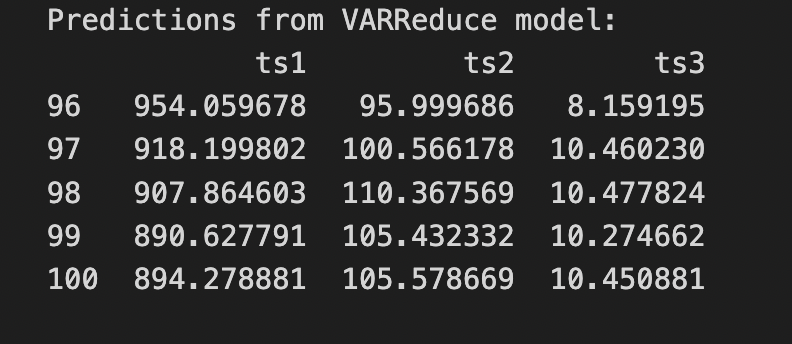

In [9]:
# Define the forecasting horizon - 5 data points (same as our df_test)
fh = ForecastingHorizon([1,2,3,4,5], is_relative=True)

# Generating forecasts from both models
df_pred_varreduce = varreduce_model.predict(fh=fh)
df_pred_statsmodels = results.forecast(df_train.values[-LAGS:], steps=len(fh))

# Compare coefficients
print("Predictions from VARReduce model:")
print(df_pred_varreduce)

print("\nPredictions from statsmodels VAR:")
print(df_pred_statsmodels)

# Compare predictions using numpy's allclose function
epsilon = 1e-8
predictions_are_close = np.allclose(df_pred_varreduce, df_pred_statsmodels, atol=epsilon)
print("\nAre the predictions from VARReduce and sktime VAR essentially the same? ", predictions_are_close)


Predictions from VARReduce model:
            ts1         ts2        ts3
96   954.059678   95.999686   8.159195
97   918.199802  100.566178  10.460230
98   907.864603  110.367569  10.477824
99   890.627791  105.432332  10.274662
100  894.278881  105.578669  10.450881

Predictions from statsmodels VAR:
[[954.05967783  95.99968573   8.15919522]
 [918.1998017  100.5661778   10.46022974]
 [907.86460253 110.36756925  10.4778239 ]
 [890.62779088 105.43233217  10.274662  ]
 [894.27888074 105.57866919  10.45088134]]

Are the predictions from VARReduce and sktime VAR essentially the same?  True


A benefit of `VARReduce` vis-a-vis `VAR` is that in the former, we are not restricted to using only `LinearRegressor` as the regressor. In fact, the user can specify any other `scikit-learn` compatible regressors to introduce regularization, which can potentially enhance performance for large datasets or when multicollinearity is present. Below are two examples:

1. **Ridge Regression (L2 Regularization)**:
   Ridge model adds a penalty proportional to the sum of the squares of the coefficients.
   It helps prevent overfitting by shrinking the coefficients.

     $$
     \min_{\beta} \sum_{i=1}^{n} (y_i - X_i \beta)^2 + \lambda \sum_{j=1}^{p} \beta_j^2
     $$


In [10]:
from sklearn.linear_model import Ridge

varreduce_model_ridge = VARReduce(lags=LAGS,
                                  regressor = Ridge(alpha = 10)) 
varreduce_model_ridge.fit(df_train)
varreduce_model_ridge.predict(fh)

,ts1,ts2,ts3
96,954.077519,96.013428,8.159868
97,918.176153,100.566330,10.459893
98,907.853466,110.363246,10.477869
99,890.636145,105.433211,10.274717
100,894.279962,105.578644,10.450806





2. **Lasso Regression (L1 Regularization)**:
   The Lasso model adds a penalty proportional to the sum of the absolute values of the coefficients.
   It can drive some coefficients to zero, effectively performing variable selection. This is especially useful when we're dealing with a large number fo time series as it can prevent overfitting.

     $$
     \min_{\beta} \sum_{i=1}^{n} (y_i - X_i \beta)^2 + \lambda \sum_{j=1}^{p} |\beta_j|
     $$


In [11]:
from sklearn.linear_model import Lasso

varreduce_model_lasso = VARReduce(lags=LAGS,
                                  regressor = Lasso(alpha = 100))  
varreduce_model_lasso.fit(df_train)
varreduce_model_lasso.coefficients_
# We note below how some coefficients are driven to zero

array([[[-4.48306604e-02, -5.00755076e-02, -3.72170608e-03],
        [-1.41189355e+00, -5.12208830e-01, -9.95940869e-02],
        [-1.89058754e+00, -2.63878913e-01, -0.00000000e+00]],

       [[ 1.04728950e-02, -4.00822026e-04,  6.79201910e-04],
        [-3.35218198e-02, -2.24104956e-03,  9.58324326e-04],
        [-3.38272978e-01, -0.00000000e+00, -0.00000000e+00]]])

# Example 2: Real World Macreconomic Data

The power of `VARReduce` becomes more evident when dealing with real-world datasets containing numerous time series. An example is the `macrodata` dataset, which contains 14 variables. This dataset is loaded below:

In [12]:
import statsmodels.api as sm

# Load the macrodata dataset using statsmodels
dataset = sm.datasets.macrodata.load_pandas()
df = dataset.data
df['year'] = df['year'].astype(int)
df['quarter'] = df['quarter'].astype(int)

# Create a datetime column
df['date'] = pd.to_datetime(df['year'].astype(str) + 'Q' + df['quarter'].astype(str))

# Set the datetime column as the index
df.set_index('date', inplace=True)

# Convert the datetime index to a period index with quarterly frequency
df.index = df.index.to_period('Q')

# Drop the original year and quarter columns if no longer needed
df.drop(columns=['year', 'quarter'], inplace=True)

df.head()

,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
date,,,,,,,,,,,,
1959Q1,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959Q2,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959Q3,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959Q4,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960Q1,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [13]:
# Split the data into training and testing sets
df_train, df_test = temporal_train_test_split(df, test_size=24)
fh = ForecastingHorizon(df_test.index, is_relative=False)

Training a traditional VAR model on this dataset with a lag of 3 means we have to fit a substantial number of parameters. Specifically, for each variable, the model needs to estimate coefficients for the current and three previous values of all 14 variables, plus an intercept. This results in a total of $14 \times$ 14 $\times 3 + 14 = 602$ parameters. Given that the number of data points is relatively small, this high number of parameters makes the model prone to overfitting, where it captures noise in the training data rather than the underlying patterns.

Overfitting leads to poor generalization to new, unseen data, resulting in inaccurate forecasts. To mitigate this, regularization techniques can be applied, which is where `VARReduce` shines. By selecting a regressor with built-in regularization properties, such as Ridge regression (L2 regularization) or Lasso regression (L1 regularization), we can introduce penalties on the size of the coefficients. This effectively controls the complexity of the model, preventing overfitting, enhancing stability, and improving the forecast accuracy.

For instance, using Lasso regression within `VARReduce` helps to manage multicollinearity and shrink the less important coefficients towards zero, making the model more interpretable and reliable. This ability to integrate advanced regression techniques allows `VARReduce` to leverage the flexibility and robustness of scikit-learn regressors, providing a powerful tool for time series forecasting in complex, high-dimensional datasets.

In [14]:
from sktime.forecasting.var import VAR

# Define lags
LAGS = 3

# Create the pipeline for VARReduce
scaler = TabularToSeriesAdaptor(StandardScaler())
varreduce_model = VARReduce(lags=LAGS, regressor = Ridge(alpha = 10))
pipeline_varreduce = ForecastingPipeline(steps=[("scaler", scaler), ("forecaster", varreduce_model)])

# Fit the pipeline
pipeline_varreduce.fit(df_train)
df_pred_varreduce = pipeline_varreduce.predict(fh=fh)

# Create the pipeline for VAR using sktime
pipeline_var = ForecastingPipeline(steps=[("scaler", scaler), ("forecaster", VAR(maxlags=LAGS))])

# Fit the pipeline
pipeline_var.fit(df_train)
df_pred_var = pipeline_var.predict(fh=fh)
df_pred_var.head()

,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
date,,,,,,,,,,,,
2003Q4,12008.166452,8370.078323,1920.789254,832.333285,9013.855549,186.457545,1309.616072,0.789749,5.816484,292.105185,3.179694,-2.387174
2004Q1,12100.740345,8434.867198,1924.814196,832.244013,9043.496495,187.578115,1321.909072,1.067490,5.501056,292.678539,2.001330,-0.934567
2004Q2,12156.027931,8485.933813,1914.768039,834.887128,9096.443801,189.054422,1335.588807,1.160220,5.235644,293.283190,3.562626,-2.402987
2004Q3,12220.562109,8534.702127,1904.231269,846.594506,9131.874290,190.473749,1352.333015,1.080410,5.003875,293.926246,3.832958,-2.753796
2004Q4,12266.944907,8570.325846,1889.896528,854.323344,9163.780890,191.914158,1367.999552,1.007891,4.937892,294.576268,3.932845,-2.926617


In [15]:
# Calculate performance metrics for VARReduce
mape_varreduce = mean_absolute_percentage_error(df_test, df_pred_varreduce)
print(f"MAPE for VARReduce model: {mape_varreduce:.2f}")

# Calculate performance metrics for statsmodels VAR
mape_var = mean_absolute_percentage_error(df_test, df_pred_var)
print(f"MAPE for statsmodels VAR model: {mape_var:.2f}")

MAPE for VARReduce model: 0.48
MAPE for statsmodels VAR model: 0.53
